In [1]:
from CVRPSolver import solve, SMALL_CONFIGS, LARGE_CONFIGS
from random import randint, seed, choice
from math import dist
import matplotlib.pyplot as plt

SEED = 0
seed(SEED)

In [2]:
def plot(routes, locations):
    def plot_route(route):
        x = [locations[loc][0] for loc in route]
        y = [locations[loc][1] for loc in route]
        plt.plot(x, y, marker='o', linestyle='-', color='b')

    for route in routes:
        plot_route(route)

    plt.xticks([])
    plt.yticks([])
    depot = locations[0]
    plt.scatter(*depot, color='r', s=100, marker='o', zorder=10)
    plt.show()


def scatter(locations):
    x = [loc[0] for loc in locations]
    y = [loc[1] for loc in locations]
    plt.scatter(x, y, marker='o', linestyle='-', color='b')
    plt.xticks([])
    plt.yticks([])
    depot = locations[0]
    plt.scatter(*depot, color='r', s=100, marker='o', zorder=10)
    plt.show()

# Generation of a small CVRP

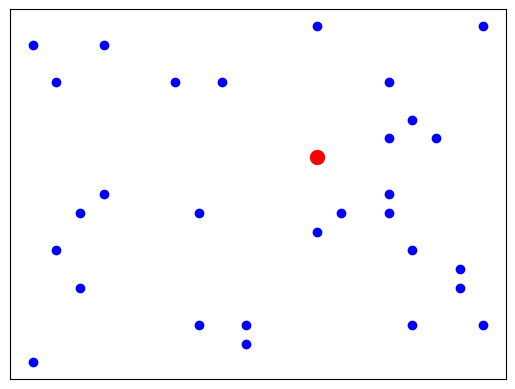

In [3]:
number_of_locations = 30
number_of_vehicles = 5
vehicle_capacity = 100

locations = [(randint(0, 20), randint(0, 20)) for _ in range(number_of_locations)]
distance_matrix = [
    [dist(locations[i], locations[j]) for i in range(number_of_locations)]
    for j in range(number_of_locations)
]

demands = [
    randint(0, 3 * vehicle_capacity * number_of_vehicles // (2 * number_of_locations))
    for _ in range(number_of_locations)
]
scatter(locations)

# Finding a solution using the CVRP solver
- The solver does not garantee an optimal solution, but the output of the solver is usually close to the optimal solution (within ~10% on the instances in `data`).

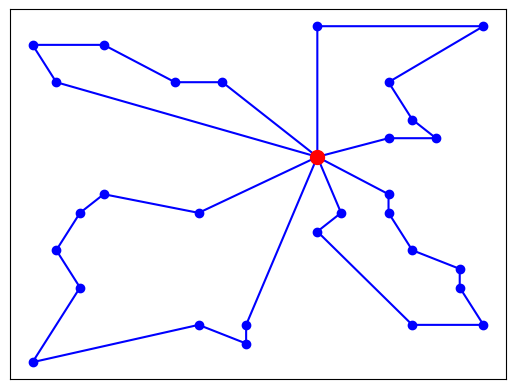

In [4]:
sol = solve(distance_matrix, locations, demands, number_of_vehicles, vehicle_capacity, {"TIME_LIMIT": 30, "SEED": SEED, "TRIES": 1})
plot([[0] + route + [0] for route in sol], locations)

# Performent configurations
I have compiled a list of `good configurations` for small (less then around 100 locations) and larger problems (around 100 - 1000 locations) using [amltk](https://automl.github.io/amltk/latest/) and instances in `data`. You should try which configuration/s fits your problem the best.

In [ ]:
SAMPLE_CONFIG_SMALL = choice(SMALL_CONFIGS).copy() | {"TIME_LIMIT": 30, "SEED": SEED, "TRIES": 1}
sol = solve(distance_matrix, locations, demands, number_of_vehicles, vehicle_capacity, SAMPLE_CONFIG_SMALL)
plot([[0] + route + [0] for route in sol], locations)

In [ ]:
SAMPLE_CONFIG_LARGE = choice(LARGE_CONFIGS).copy() | {"TIME_LIMIT": 30, "SEED": SEED, "TRIES": 1}
sol = solve(distance_matrix, locations, demands, number_of_vehicles, vehicle_capacity, SAMPLE_CONFIG_LARGE)
plot([[0] + route + [0] for route in sol], locations)